In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Lambda, Input, Dense, Reshape
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os

from mpl_toolkits.mplot3d import Axes3D
from IPython.display import HTML

# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    thre = K.random_uniform(shape=(batch,1))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


/Users/wuzhejun/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# 1. Data Simulation
## 1.1 Simulating State Sequence
We first simulate a state sequence of 50000 time points (t=50000) containting 10 different connectivity states ($s \in \{0,...,9\}$). Here the states of the first 1000 time points are shown below.

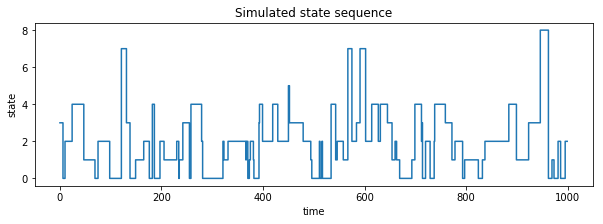

In [3]:
np.random.seed(seed=0)

# simulate state-space series
state_num = 10
time_len = 50000
display_num = 1000
signal_dimension = 10
CNR = 10
window_len = 11
half_window_len = 5

# state transition matrix
a = np.ones(shape=(state_num,state_num))
alpha = np.ones(10)*10
alpha[5:] = 1;
base_prob = np.random.dirichlet(alpha) * 0.1
for t in range(state_num):
    a[t,:] = base_prob
    a[t,t] += 0.9

# simulate states 
state = np.zeros(time_len,dtype=np.uint8)
p = np.random.uniform()
state[0] = np.floor(p*state_num)
for t in range(0,time_len-1):
    p = np.random.uniform()
    for s in range(state_num):
        if (p <= np.sum(a[state[t],:s+1])):
            state[t+1] = s
            break

# plot first few states            
plt.figure(figsize=(10,3))
plt.step(range(display_num),state[window_len:window_len+display_num])
plt.xlabel('time')
plt.ylabel('state')
plt.title('Simulated state sequence');

The frequency of each state is listed below. The first 5 states are 'major' states, and the last 5 states are 'minor' states. This frequency is controlled by a Dirichlet distribution: $Dir(10,...,1,...)$. Note in the above figure there is no state 6 and state 9 existing in the first 1000 time points due to low frequency.

In [4]:
freq = np.zeros(state_num)
for t in range(state_num):
    freq[t] = np.sum(state == t)
freq

array([13123.,  8364., 12489.,  5148.,  7607.,   546.,   613.,  1869.,
         122.,   119.])

## 1.2 Simulating Bold Signal
For each state, the BOLD signal is generated by a state-specific loading pattern. We assume there are 10 brain regions, so the BOLD is 10*50000. Here the BOLD signals of the first 1000 time points are shown below.

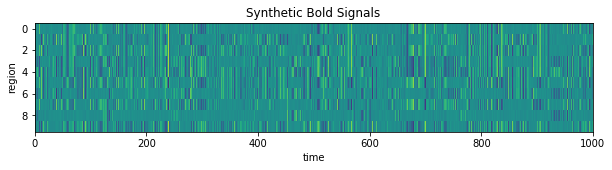

In [5]:
# different states have different loading (connectivity)
loading = np.random.randint(-1, 2,size=(state_num,signal_dimension))
cov = np.zeros((state_num,signal_dimension,signal_dimension))
for t in range(state_num):
    cov[t,:,:] = np.matmul(np.transpose([loading[t,:]]),[loading[t,:]])

# generate BOLD signal
signal = np.zeros((time_len,signal_dimension))
for t in range(0,time_len):
    signal[t,:] = np.random.multivariate_normal(np.zeros((signal_dimension)), cov[state[t],:,:])
signal += np.random.normal(size=signal.shape)/CNR
plt.figure(figsize=(10,2))
plt.imshow(np.transpose(signal[window_len:window_len+display_num,:]),aspect='auto')
plt.xlabel('time')
plt.ylabel('region')
plt.title('Synthetic Bold Signals');

## 1.3 Simulating Correlation Matrices
Sliding-window-based correlation matrices are generated based on the above BOLD. The sliding window has a length of 10 time points. Here I vectorized the upper triangular matrix at each time point.

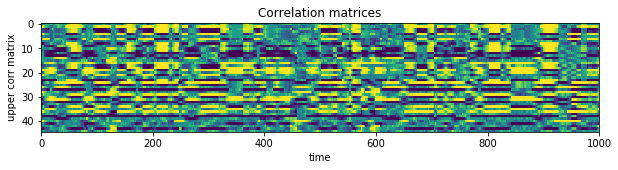

In [6]:
# generate corr matrices
original_dim = np.uint32(signal_dimension*(signal_dimension-1)/2)

x_train = np.zeros(shape=(time_len-window_len*2,np.uint32(original_dim)))
sum_corr = np.zeros(shape=(state_num,original_dim))
occupancy = np.zeros(state_num)

for t in range(window_len,time_len-window_len):
    corr_matrix = np.corrcoef(np.transpose(signal[t-half_window_len:t+half_window_len+1,:]))
    upper = corr_matrix[np.triu_indices(signal_dimension,k=1)]
    x_train[t-window_len,:] = np.squeeze(upper)
    if (np.sum(state[t-half_window_len:t+half_window_len+1] == state[t]) == window_len):
        sum_corr[state[t],:] += x_train[t-window_len,:]
        occupancy[state[t]] += 1

plt.figure(figsize=(10,2))
plt.imshow(np.transpose(x_train[:display_num,:]),aspect='auto')
plt.xlabel('time')
plt.ylabel('upper corr matrix')
plt.title('Correlation matrices');

The correlation matrices associated with each state are collected and averaged, which is called the state-specific mean correlation matrix. The mean correlation matrices associated with the first 5 states are shown below

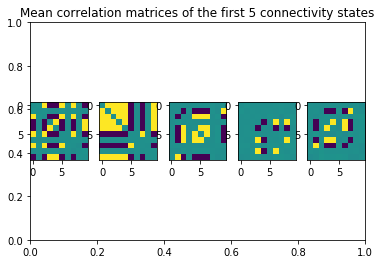

In [7]:
tmp_corr = np.zeros(shape=(signal_dimension,signal_dimension))
mean_corr = sum_corr.copy()

fig = plt.figure()
plt.title("Mean correlation matrices of the first 5 connectivity states")
for i in range(5):
    ax = fig.add_subplot(1,5,i+1)
    if occupancy[i] > 0:
        mean_corr[i,:] = sum_corr[i,:] / occupancy[i]
        tmp_corr[np.triu_indices(signal_dimension,k=1)] = mean_corr[i,:]
    else :
        tmp_corr[np.triu_indices(signal_dimension,k=1)] = 0
    ax.imshow(tmp_corr+np.transpose(tmp_corr))


# Clustering Correlation Matrices using GMM
We first use GMM to cluster the data (upper triangular matrices) using 5 clusters (the number of major clusters).

In [8]:
from sklearn.mixture import GaussianMixture
class_num = 5
gmm = GaussianMixture(n_components=class_num).fit(x_train)
labels = gmm.predict(x_train)

Based on the GMM clustering results, the estimated 5 mean correlation matrices are the following (this would be the final useful results for real data representating major connectivity patterns). Note GMM won't yield a correct order of the states, so the order shown below is derived by comparing estimated mean correlation matrices with ground-truth.

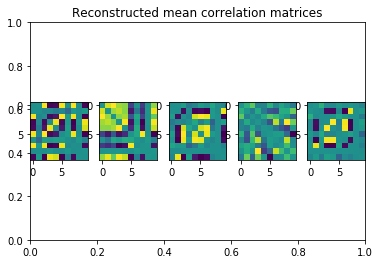

In [9]:
tmp_corr = np.zeros(shape=(signal_dimension,signal_dimension))
recon_mean_corr = mean_corr.copy()
dist = np.zeros(state_num)
perm_link = np.zeros(class_num)

fig = plt.figure()
plt.title("Reconstructed mean correlation matrices")
for i in range(class_num):
    recon_mean_corr[i,:] = np.mean(x_train[labels == i,:],axis = 0)
    for t in range(state_num):
        dist[t] = np.linalg.norm(recon_mean_corr[i,:]-mean_corr[t,:])
    perm_link[i] = np.argmin(dist)
    
for i in range(class_num):
    ax = fig.add_subplot(1,class_num,np.uint32(perm_link[i])+1)
    tmp_corr[np.triu_indices(signal_dimension,k=1)] = recon_mean_corr[i,:]
    ax.imshow(tmp_corr+np.transpose(tmp_corr))
#perm_link

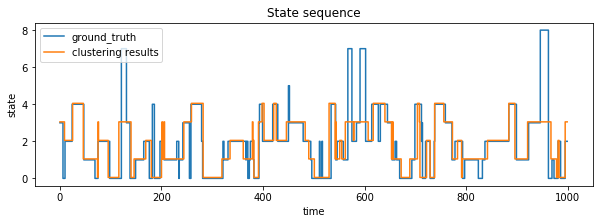

In [10]:
recon_state = labels.copy()
for t in range(labels.shape[0]):
    recon_state[t] = perm_link[np.uint32(labels[t])]
    
# plot first few states            
plt.figure(figsize=(10,3))
plt.step(range(display_num),state[window_len:window_len+display_num])
plt.step(range(display_num),recon_state[:display_num]+0.05)
plt.xlabel('time')
plt.ylabel('state')
plt.title('State sequence')
plt.legend(['ground_truth','clustering results'])

The estimated states (orange) derived by GMM are overlaid with ground-truth (blue). The accuracy (%) of state estimation is shown below. Since GMM only uses 5 clusters, the 'minor' clusters are forced to be assigned to 'major' clusters.

In [11]:
# accuracy
state_partial = state[window_len:window_len+recon_state.shape[0]]
#state_partial.shape
np.sum(recon_state == state_partial) / recon_state.shape[0]

0.7315018608187602